## Семинар 3 "Определение ключевых точек лица"

ФИО:

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


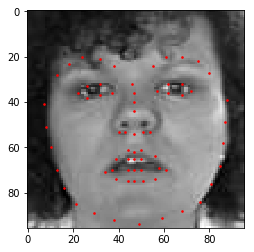

In [1]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, ReLU, ELU
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [5]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True)

In [21]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=MSELoss(), optim=torch.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
        return train_loss_epochs, test_loss_epochs
    except KeyboardInterrupt:
        pass

In [12]:
network = Sequential(Linear(1 * 96 * 96, 200), Tanh(),
               Linear(200, 2 * 68))

In [ ]:
train(network, 4, 1e-1)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=4)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(-1, 96 * 96).type(dtype))
y_pred = network(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)

Начнем, пожалуй)

Сначала сравним все однослойные нейронные сети с различными функциями активациями.
Чтобы сравнение было адекватным будем сравнивать их при различных learning_rate.


In [53]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
activations = [Sigmoid(), Tanh(), ReLU(), ELU()]

Epoch 9... (Train/Test) MSE: 100.932/159.89311

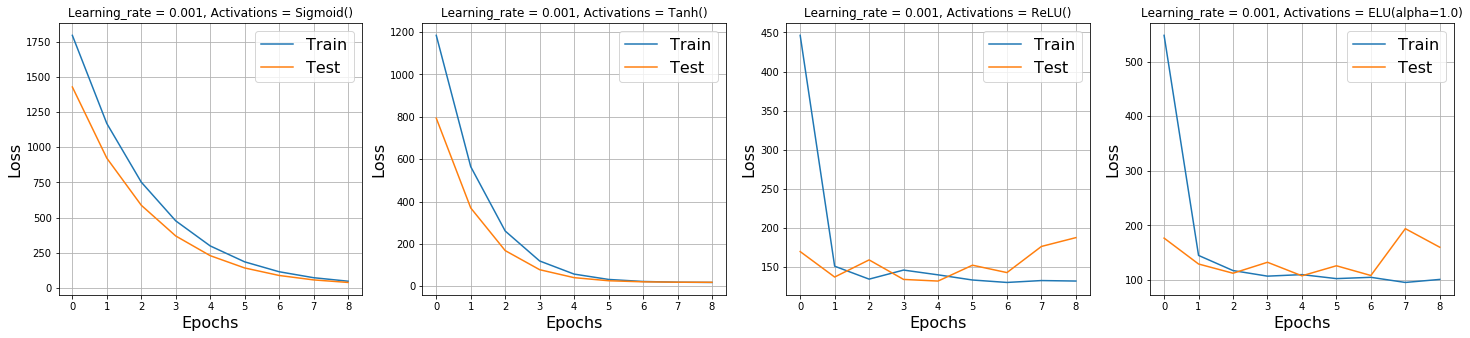

Epoch 9... (Train/Test) MSE: 34.923/29.610142864

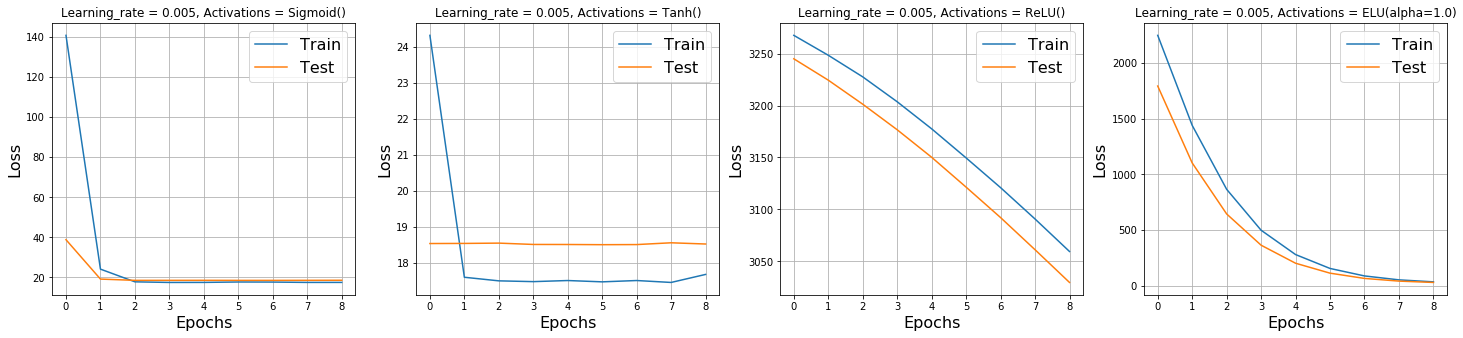

Epoch 9... (Train/Test) MSE: 53.187/41.7274710026

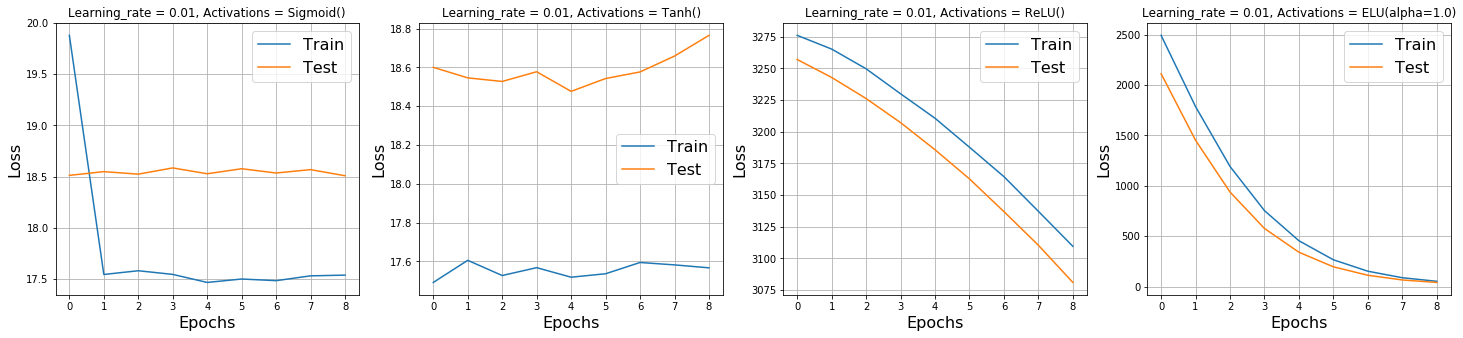

Epoch 9... (Train/Test) MSE: 750.552/685.076400.373

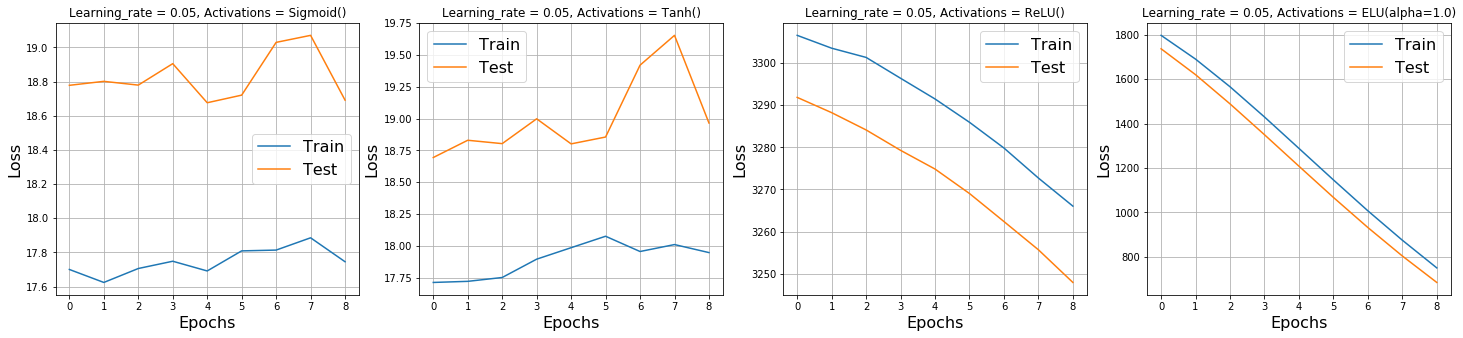

Epoch 9... (Train/Test) MSE: 372.031/334.1154077.401

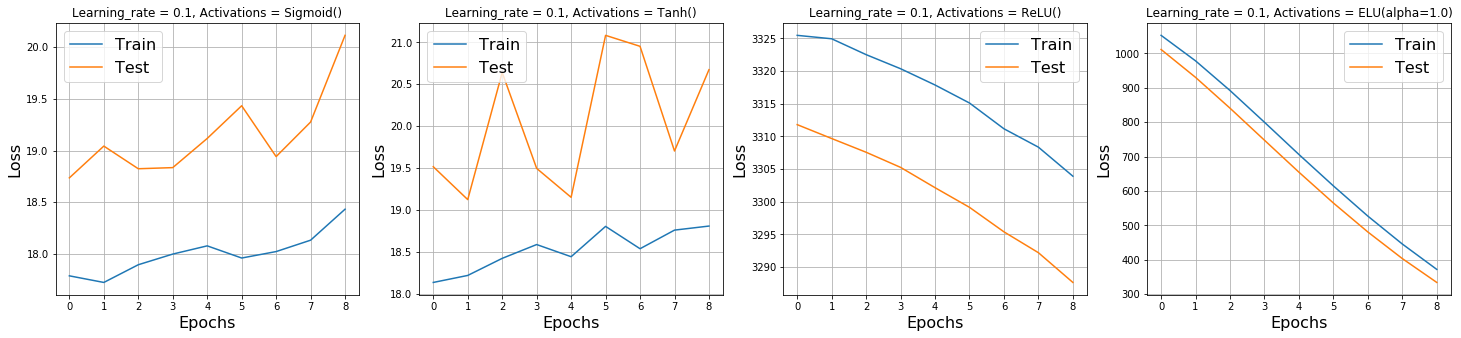

In [57]:
for ln_rate in learning_rates:
    fig = plt.figure(14, figsize=(25, 5))
    for i, activation in enumerate(activations):
        network = Sequential(Linear(1 * 96 * 96, 200),
                             activation,
                             Linear(200, 2 * 68))
        train_loss_epochs, test_loss_epochs = train(network, 10, ln_rate)
        fig.add_subplot(1, 4, i + 1)
        plt.plot(train_loss_epochs[1:], label='Train')
        plt.plot(test_loss_epochs[1:], label='Test')
        plt.title("Learning_rate = {0}, Activations = {1}".format(ln_rate, network[1]))
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
    plt.show()

Теперь давайте рассмотрим двуслойные нейронные сети

In [58]:
learning_rates = [0.001, 0.005, 0.01]
activations = [
    [Sigmoid(), ReLU()],
    [Tanh(), ReLU()],
    [Sigmoid(), Tanh()]
]

Epoch 9... (Train/Test) MSE: 17.986/18.5852498

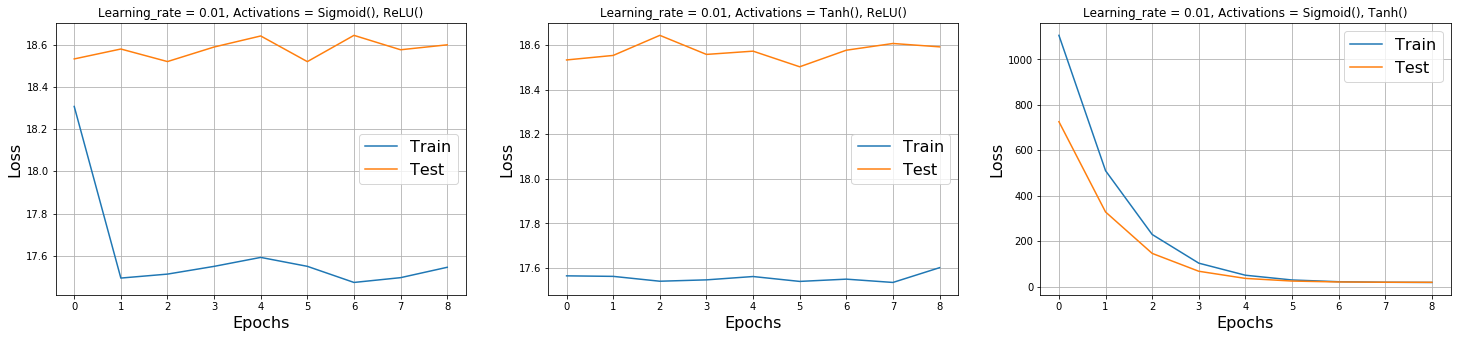

Epoch 9... (Train/Test) MSE: 17.496/18.6195

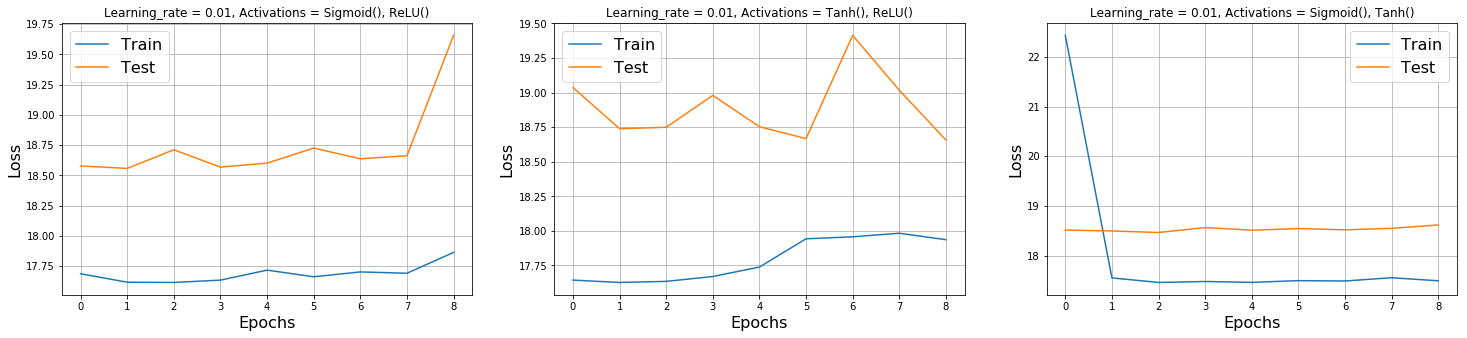

Epoch 9... (Train/Test) MSE: 17.558/18.5953

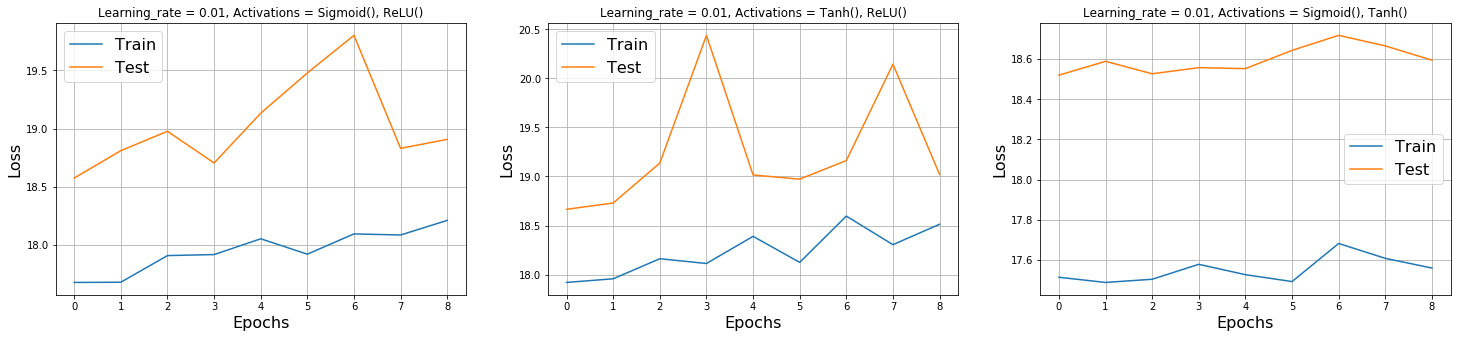

In [59]:
for ln_rate in learning_rates:
    fig = plt.figure(13, figsize=(25, 5))
    for i, activation in enumerate(activations):
        network = Sequential(Linear(1 * 96 * 96, 200),
                             activation[0],
                             Linear(200, 200),
                             activation[1],
                             Linear(200, 2 * 68))
        train_loss_epochs, test_loss_epochs = train(network, 10, ln_rate)
        fig.add_subplot(1, 3, i + 1)
        plt.plot(train_loss_epochs[1:], label='Train')
        plt.plot(test_loss_epochs[1:], label='Test')
        plt.title("Learning_rate = {0}, Activations = {1}, {2}".format(learning_rate, activation[0], activation[1]))
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
    plt.show()

### Помарка
***
1 слой соответствует значению learning_rate = 0.001
***
2 слой соответствует значению learning_rate = 0.005
***
3 слой соответствует значению learning_rate = 0.01
***
Не стал переобучать, так как они обучаются очень очень долго)

# Выводы
***
Я обучил 35 нейронных сетей, 20 однослойных и 15 двуслойных.
***
Каждая сеть обучалась 10 эпох, по моему мнению этого достаточно, чтобы отследить скорость снижения лосса для маленьких learning_rates и посмотреть сколько эпох нужно для больших.
***
## Проанализируем однослойные слои с разными learning_rates
***
#### learning_rate = 0.001
Самую лучший результат показали Tanh() и Sigmoid(), ReLU() начал очень хорошо, но потом остановился и перестал обучаться, ELU() аналогично ReLU(), но итоговый результат показала лучше.
***
#### learning_rate = 0.005
Самую лучшую сходимость показали Tanh() и Sigmoid(), ReLU() не вытаскивает, показывает достаточно плохой результат, видимо, нужно увеличить либо колличество эпох, либо learning_rate, но, честно говоря, причины для меня непонятны, ELU() справился тоже очень хорошо.
***
#### learning_rate = 0.01
Самую лучшую сходимость показали Sigmoid() и Tanh(), но мы можем заметить, что под конец Tanh() начинате переобучаться, ReLU() показывает достаточно плохой результат, ELU() справился лучше.
***
#### learning_rate = 0.05
Tanh() и Sigmoid() начинают сильно переобучаться, значит, для них такой показатель learning_rate слишком велик.
ReLU() и ELU() показывают результат хуже, но они более устойчивы.
***
#### learning_rate = 0.1
Tanh() и Sigmoid() начинают сильно переобучаться, значит, для них такой показатель learning_rate слишком велик.
ReLU() и ELU() показывают результат хуже, но они более устойчивы.
***
## Проанализируем двуслойные слои
Теперь я хочу проанализировать каждую двуслойную нейронку в зависимости от learning_rate, а потом сравнить их лучшие результаты между собой, мне кажется, такой взгляд подойдет сюда лучше.
***
Вследствие полученых на предыдущем шаге результатов я решил не обучать нейронки на последних значениях learning_rate, так как даже на однослойных мы видели сильное переобучение.
***
#### Sigmoid(), ReLU()
Можно сказать, что результаты мало различаются, но с увеличением learning_rate и эпох, нейронка начинает переобучаться.
***
#### Tanh(), ReLU()
Результаты мало различаются, но с увеличением learning_rate и эпох, нейронка начинает переобучаться еще сильнее, чем предыдущая.
***
#### Sigmoid(), Tanh()
Показывает наилучшую устойчивость и отличный результат при любых learning_rate.
***
Все три нейронки достигли порога 17.6 при различных показателях learning_rate.